In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pprint import pprint
from itertools import product
import json



## Narma10
Non linear autoregressive moving average task: we have two time series, $X=(x_t)$ and $Y=(y_t)$. The input sequence $X$ is chosen randomly in $[0, 0.5]$.

The target ts $y$ is defined by
$$ y(t)=0.3 y(t-1) + 0.05 y(t-1) \left( \sum_{i=1}^{10} y(t-i)\right) +1.5 x(t-10)x(t-1) + 0.1$$
The goal, given the input $x(t)$, is to predict $y(t)$.

In [193]:
df = pd.read_csv('../dataset/NARMA10.csv', header=None)
x = torch.Tensor(df.iloc[0,:])
y = torch.Tensor(df.iloc[1,:])

In [194]:
x =x.unsqueeze(0)
y =y.unsqueeze(0)
x.shape, y.shape

(torch.Size([1, 10000]), torch.Size([1, 10000]))

In [195]:
x_train = x[:, :4000]
x_val = x[:, 4000:5000]
x_dev = x[:, :5000] # train + val
x_test = x[:, 5000:]
y_train = y[:, :4000]
y_val = y[:, 4000:5000]
y_dev = y[:, :5000] # train + val
y_test = y[:, 5000:]

x_dev.shape, y_dev.shape

(torch.Size([1, 5000]), torch.Size([1, 5000]))

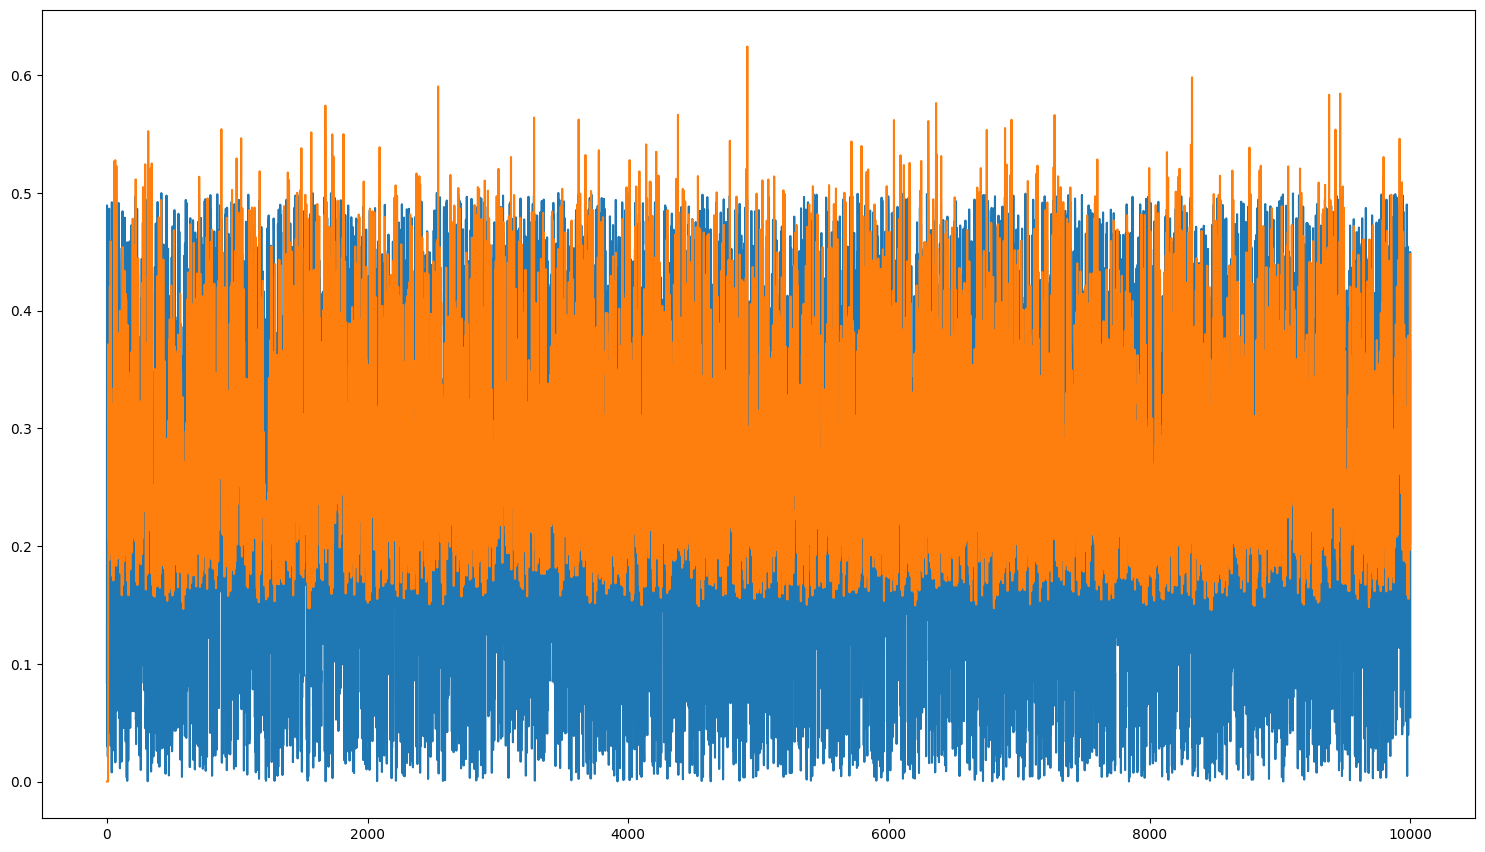

In [11]:
fig, ax = plt.subplots()

plt.plot( torch.arange(10000), x[0,:], y[0,:])
# adjust figure size
fig.set_size_inches(18.5, 10.5)
plt.show()

## TDNN
The first model is a Time Delay NN (TDNN). This type of network consist in a 1D convolution without stride, or equivalently a standard multi layer perceptron applied to a fixed size window of the input:
if $X = (x_t)_{t=1}^{T}$ is the input time series, a TDNN applies the same MLP to  $(x_{t-\tau},...,x_{t})$, where $\tau$ is the window size.

I opted for a very simple implementation, consisting in one hidden ReLU MLP layer. The time delay is obtained by simply sliding the MLP along the time series

In [192]:
class TDNN(nn.Module):
    def __init__(self, window_size:int, hidden_size: int, output_size:int):
        super(TDNN, self).__init__()
        self.window_size =window_size
        self.td = nn.Linear(window_size, hidden_size)   
        self.relu=nn.ReLU()
        self.linear = nn.Linear(hidden_size, output_size)
    
    def pad_input(self, x:torch.Tensor):
        pad_size = self.window_size - x.shape[1]
        return torch.cat(torch.zeros(1, pad_size), x)

    def forward(self, x:torch.Tensor):
        """
        just a 2 layer feedforward network applied on time windows of the input
        """
        if x.shape[1] < self.window_size:
            x= self.pad_input(x)
        h = self.relu(self.td(x))
        o = self.linear(h)
        return o.squeeze(0)
        

In [12]:
y_val.mean()

tensor(0.2773)

In [13]:
x=torch.tensor([[1]])
x.squeeze(0).shape, x.squeeze(0)

(torch.Size([1]), tensor([1]))

In the first experiment, we feed the network the inputs $x(t- \tau),..., x(t)$, where $\tau =10$ is the window size. The window size is clearly ideal from the specifications of the problem.

### Training Loop

In [197]:


def train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=100, n_steps_update=32, patience=5, eps=1e-5):
    train_losses_tdnn = []
    train_maes_tdnn = []
    val_losses_tdnn = []
    val_maes_tdnn = []

    
    best_val_loss = np.inf
    patience_counter = 0
    
    for epoch in range(epochs):
        running_loss = 0
        running_mae = 0
        print(f'Epoch {epoch + 1}')
        
        # Training phase
        tdnn.train()
        train_progress = tqdm(range(tdnn.window_size - 1, x_train.shape[1]), desc='Training', leave=False)
        for i in train_progress: # iterate over the time series in windows
            x_i = x_train[:, i - tdnn.window_size + 1: i + 1]
            y_hat = tdnn(x_i)
            l = loss_fn(y_hat, y_train[:, i])
            m = mae_fn(y_hat, y_train[:, i])
            running_loss += l.item()
            running_mae += m.item()
            l.backward()
            if i % n_steps_update == 0 or i == x_train.shape[1] - 1:
                optimizer.step()
                optimizer.zero_grad()
            
                train_progress.set_postfix({'loss': running_loss / (i + 1), 'mae': running_mae / (i + 1)})
        
        running_loss /= x_train.shape[1]
        running_mae /= x_train.shape[1]
        train_losses_tdnn.append(running_loss)
        train_maes_tdnn.append(running_mae)
        print(f'Training loss: {running_loss:.4f}')
        print(f'Training MAE: {running_mae:.4f}')
        print('Relative MAE: ', running_mae / y_train.abs().mean().item())

        # Validation phase
        if x_val is None or y_val is None:
            continue
        # else, evaluate the model on the validation set
        tdnn.eval()
        val_loss = 0
        val_mae = 0
        y_hats = torch.Tensor()
        val_progress = tqdm(range(tdnn.window_size - 1, x_val.shape[1]), desc='Validation', leave=False)
        for i in val_progress:
            x_i = x_val[:, i - tdnn.window_size + 1: i + 1]
            with torch.no_grad():
                y_hat = tdnn(x_i)
                y_hats = torch.cat((y_hats, y_hat))
                val_loss += loss_fn(y_hat, y_val[:, i]).item()
                val_mae += mae_fn(y_hat, y_val[:, i]).item()
            
            val_progress.set_postfix({'val_loss': val_loss / (i + 1), 'val_mae': val_mae / (i + 1)})
        
        val_loss /= x_val.shape[1]
        val_mae /= x_val.shape[1]
        val_losses_tdnn.append(val_loss)
        val_maes_tdnn.append(val_mae)
        print(f'Validation loss: {val_loss:.4f}')
        print(f'Validation MAE: {val_mae:.4f}')
        print('Relative MAE: ', val_mae / y_val.abs().mean().item())
        print('-----------------------------------')
        # Early stopping
        if val_loss < best_val_loss - eps:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break
    return train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch



### Grid Search

In [ ]:

window_sizes = [10, 20, ]
hidden_sizes = [10, 20, 50]
learning_rates= [0.001, 0.005, 0.01]
results = dict()

for window_size, hidden_size, lr in product(window_sizes, hidden_sizes, learning_rates):
    print(f'Window size: {window_size}, Hidden size: {hidden_size}, Learning rate: {lr}')
    tdnn = TDNN(window_size, hidden_size, 1)
    optimizer = torch.optim.Adam(tdnn.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=20)
    results[(window_size, hidden_size, lr)] = (train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch)

### Results

In [35]:
for result in results:
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = results[result]
    print(f'Window size: {result[0]}, Hidden size: {result[1]}, Learning rate: {result[2]}')
    print(f'Epochs: {epoch}')
    print(f'Min validation loss: {min(val_losses_tdnn)}')
    print(f'Min validation MAE: {min(val_maes_tdnn)}')
    print('-----------------------------------')

best_result = min(results, key=lambda x: min(results[x][2])) # Find the best result based on the minimum validation loss
print(f'Best result: {best_result}')

Window size: 10, Hidden size: 10, Learning rate: 0.001
Epochs: 12
Min validation loss: 0.004432410151622533
Min validation MAE: 0.05107758082449436
-----------------------------------
Window size: 10, Hidden size: 10, Learning rate: 0.005
Epochs: 9
Min validation loss: 0.004457385072661982
Min validation MAE: 0.05098542748391628
-----------------------------------
Window size: 10, Hidden size: 10, Learning rate: 0.01
Epochs: 8
Min validation loss: 0.0045679084547753145
Min validation MAE: 0.051872932329773906
-----------------------------------
Window size: 10, Hidden size: 20, Learning rate: 0.001
Epochs: 19
Min validation loss: 0.0044961850985485935
Min validation MAE: 0.05127912466228008
-----------------------------------
Window size: 10, Hidden size: 20, Learning rate: 0.005
Epochs: 6
Min validation loss: 0.0046219773856710925
Min validation MAE: 0.05218025200068951
-----------------------------------
Window size: 10, Hidden size: 20, Learning rate: 0.01
Epochs: 6
Min validation l

### Second Grid Search

Since the best hyperparameters were at the extremes of the grid intervals, I'm now trying with more complex models

In [ ]:

window_sizes = [20, 30, 50]
hidden_sizes = [50, 100]
learning_rates= [0.01]
results = dict()

for window_size, hidden_size, lr in product(window_sizes, hidden_sizes, learning_rates):
    tdnn = TDNN(window_size, hidden_size, 1)
    optimizer = torch.optim.Adam(tdnn.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = train_tdnn(tdnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, epochs=20)
    results[(window_size, hidden_size, lr)] = (train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch)

In [93]:
for result in results:
    train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = results[result]
    print(f'Window size: {result[0]}, Hidden size: {result[1]}, Learning rate: {result[2]}')
    print(f'Epochs: {epoch}')
    print(f'Min validation loss: {min(val_losses_tdnn)}')
    print(f'Min validation MAE: {min(val_maes_tdnn)}')
    print('-----------------------------------')

best_result = min(results, key=lambda x: min(results[x][2])) # Find the best result based on the minimum validation loss
print(f'Best result: {best_result}')


Window size: 20, Hidden size: 50, Learning rate: 0.01
Epochs: 19
Min validation loss: 5.852516065383995e-05
Min validation MAE: 0.006204021707177162
-----------------------------------
Window size: 20, Hidden size: 100, Learning rate: 0.01
Epochs: 15
Min validation loss: 3.9085319685130184e-05
Min validation MAE: 0.004905495285987854
-----------------------------------
Window size: 30, Hidden size: 50, Learning rate: 0.01
Epochs: 19
Min validation loss: 4.456448583137362e-05
Min validation MAE: 0.005222466170787811
-----------------------------------
Window size: 30, Hidden size: 100, Learning rate: 0.01
Epochs: 14
Min validation loss: 5.106105526285254e-05
Min validation MAE: 0.005535427898168564
-----------------------------------
Window size: 50, Hidden size: 50, Learning rate: 0.01
Epochs: 13
Min validation loss: 0.00038556705258748994
Min validation MAE: 0.015526793956756591
-----------------------------------
Window size: 50, Hidden size: 100, Learning rate: 0.01
Epochs: 18
Min v

#### Training curve

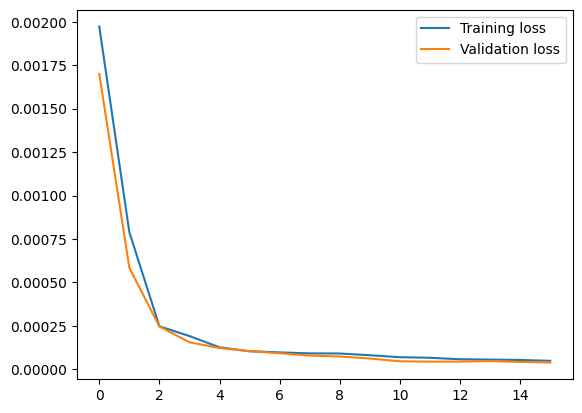

In [101]:
# get best result
train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = results[best_result]

# plot training and validation losses
fig, ax = plt.subplots()
plt.plot(train_losses_tdnn, label='Training loss')
plt.plot(val_losses_tdnn, label='Validation loss')
plt.legend()

### Retraining

In [ ]:
# retrains the model with the best hyperparameters
window_size, hidden_size, lr = best_result
final_tdnn = TDNN(window_size, hidden_size, 1)
optimizer = torch.optim.Adam(final_tdnn.parameters(), lr=lr)
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
train_losses_tdnn, train_maes_tdnn, val_losses_tdnn, val_maes_tdnn, epoch = train_tdnn(final_tdnn, optimizer, loss_fn, mae_fn, x_dev, y_dev, None, None, epochs=20)

### Testing and Visualizations

In [210]:
# predict the training set
y_hats = torch.Tensor()
for i in range(final_tdnn.window_size - 1, x_dev.shape[1]):
    x_i = x_dev[:, i - final_tdnn.window_size + 1: i + 1]
    with torch.no_grad():
        y_hat = final_tdnn(x_i)
        y_hats = torch.cat((y_hats, y_hat))



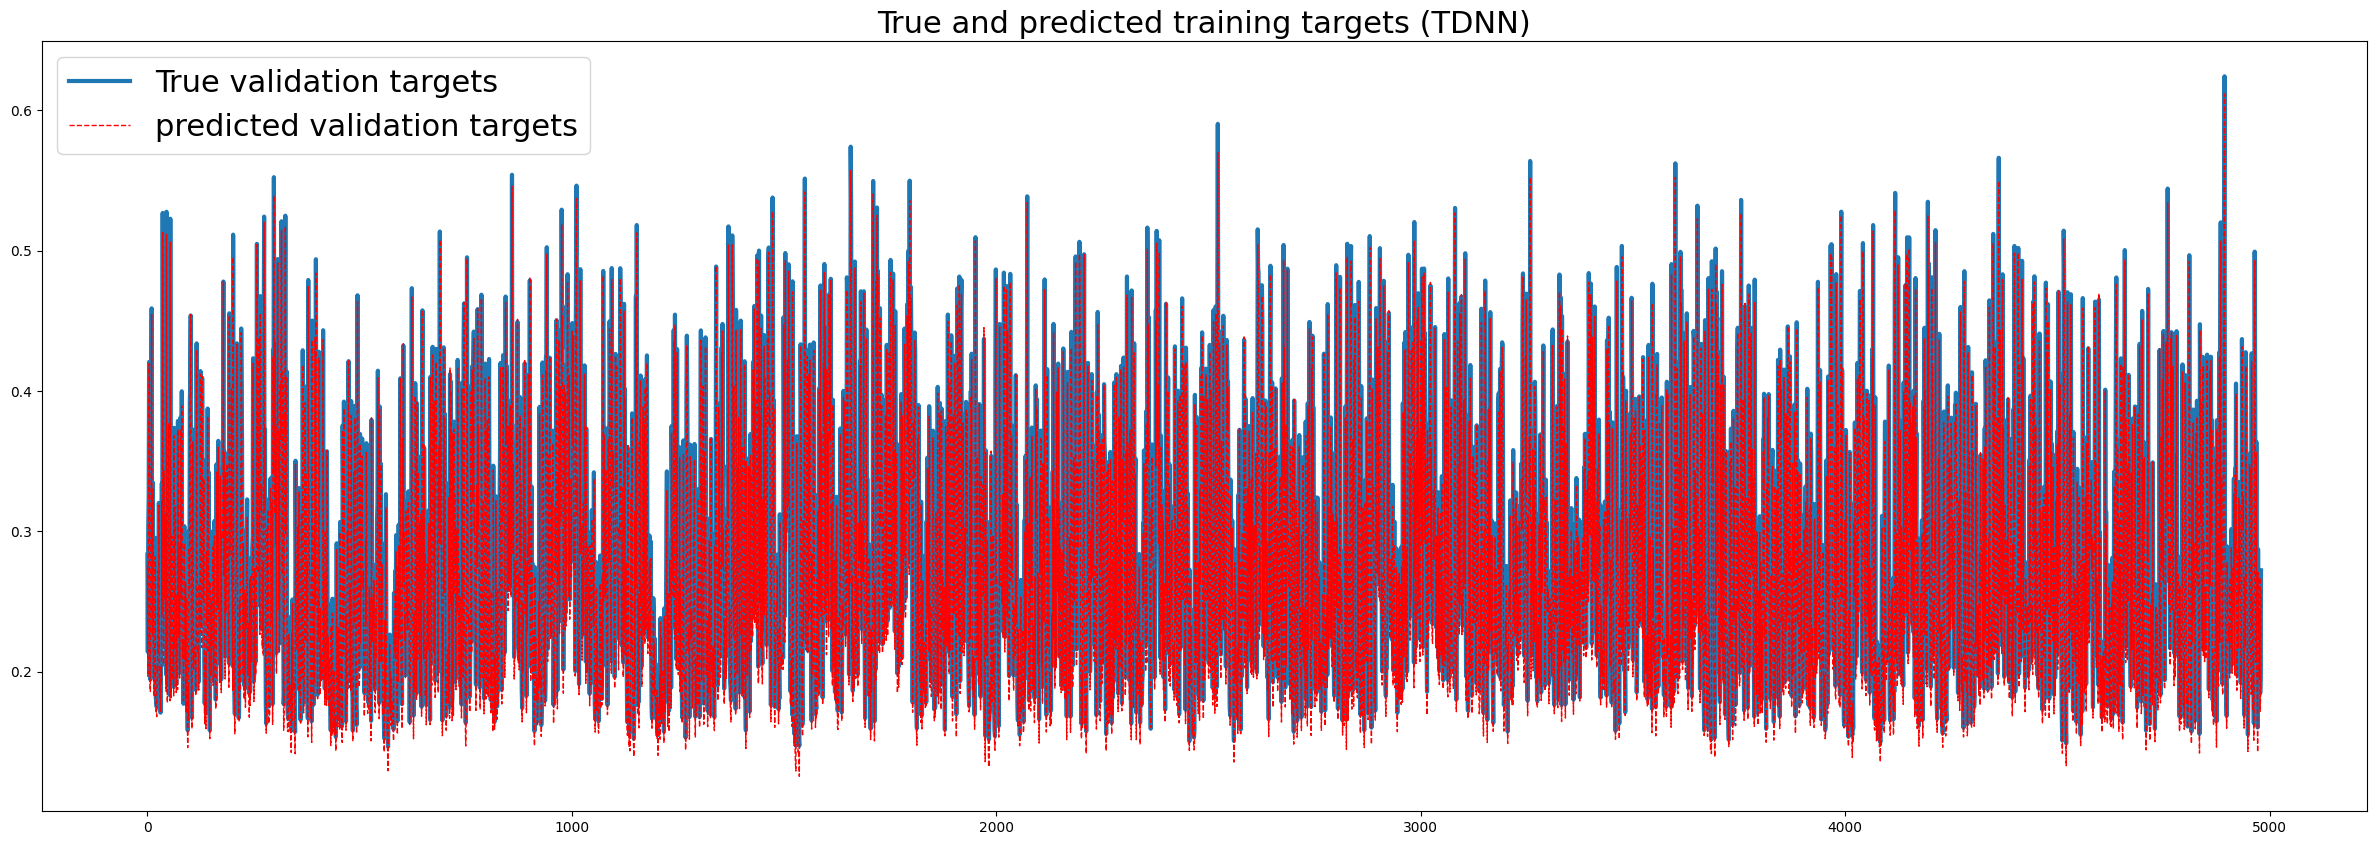

In [211]:
plt.figure(figsize=(30,10))
y_hats = y_hats.reshape(-1)
plt.plot(y_dev.reshape(-1)[19:], label ='True validation targets', linewidth=3)
plt.plot(y_hats, label ='predicted validation targets', linestyle = '--', color='r', linewidth=1)
plt.legend(fontsize=22)
plt.title('True and predicted training targets (TDNN)', fontsize=22)
plt.show()

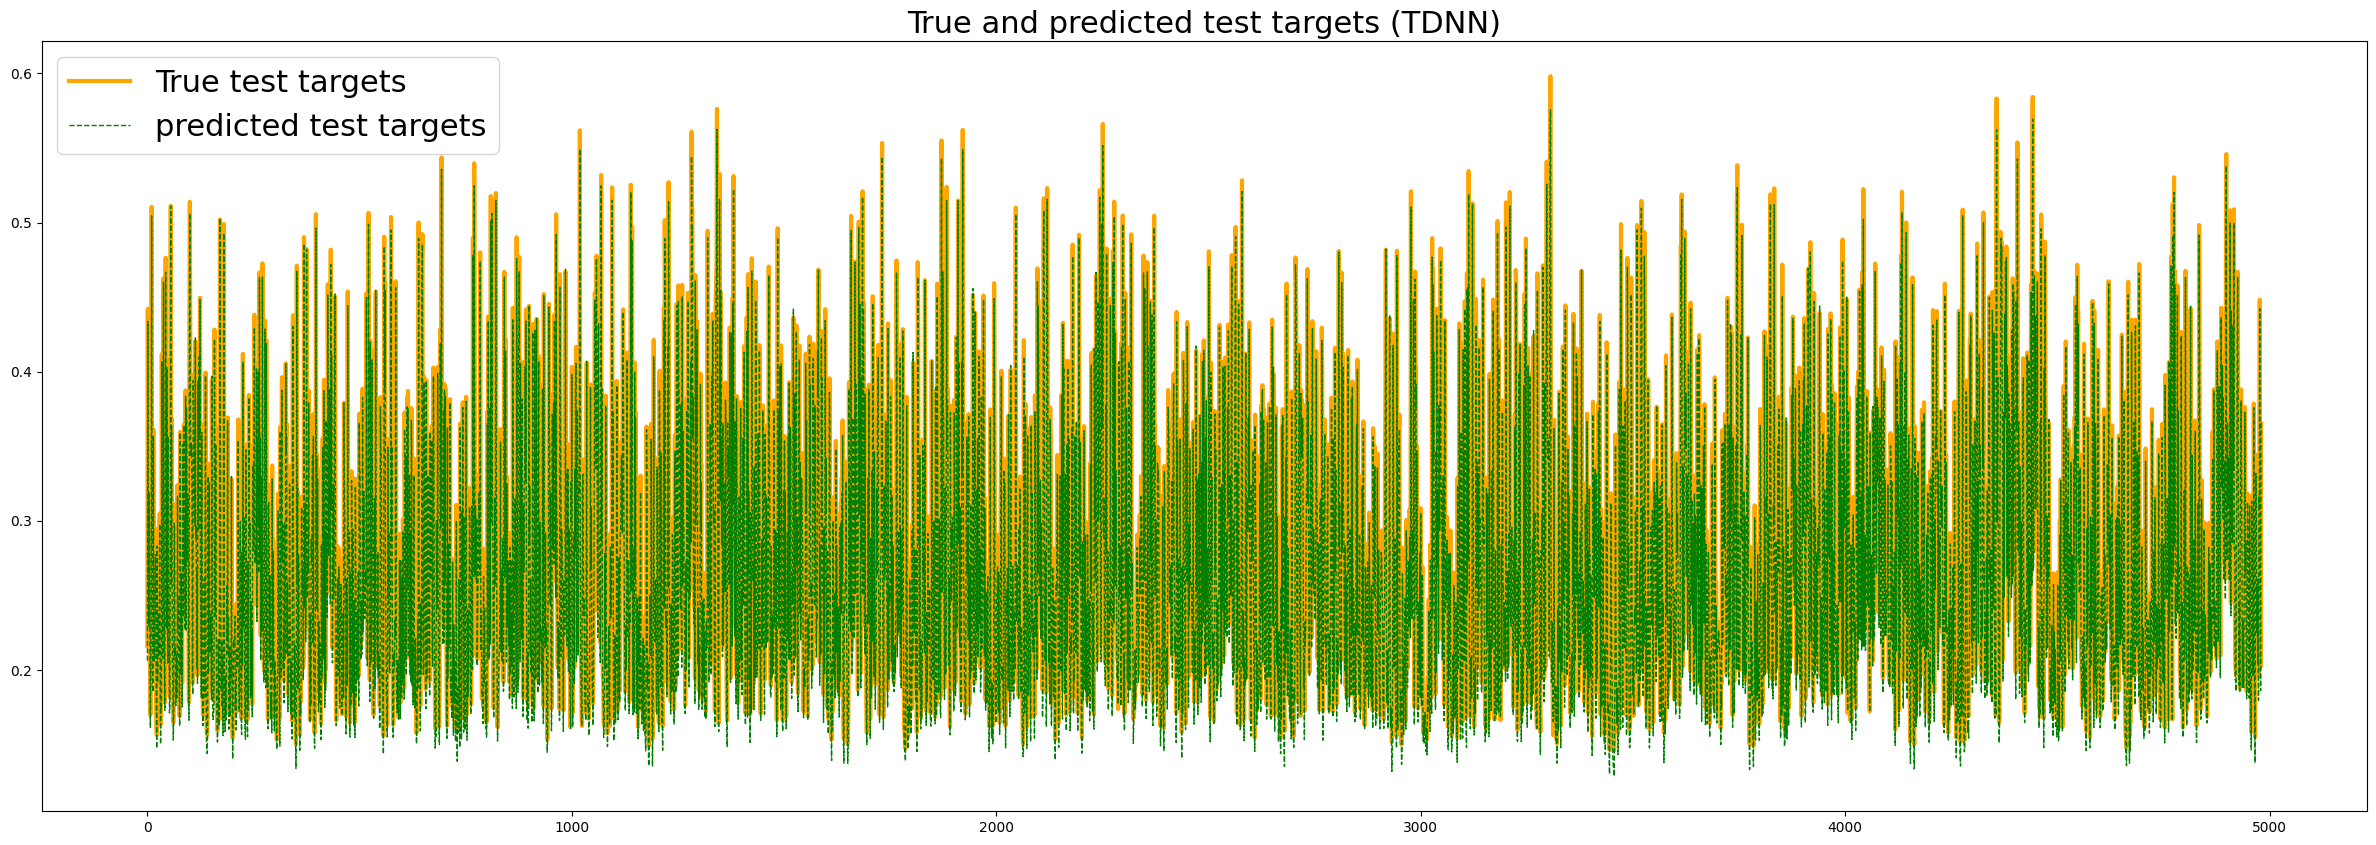

In [212]:
# predict the test set
y_hats_test_tdnn = torch.Tensor()
for i in range(final_tdnn.window_size - 1, x_test.shape[1]):
    x_i = x_test[:, i - final_tdnn.window_size + 1: i + 1]
    with torch.no_grad():
        y_hat = final_tdnn(x_i)
        y_hats_test_tdnn = torch.cat((y_hats_test_tdnn, y_hat))

plt.figure(figsize=(30,10))
y_hats_test_tdnn = y_hats_test_tdnn.reshape(-1)
plt.plot(y_test.reshape(-1)[19:], label ='True test targets', linewidth=3, color='orange')
plt.plot(y_hats_test_tdnn, label ='predicted test targets', linestyle = '--', color='g', linewidth=1)
plt.title('True and predicted test targets (TDNN)', fontsize=22)
plt.legend(fontsize=22)

plt.show()


In [217]:
final_results = dict()
final_results['TDNN'] = dict()
final_results['TDNN']['hyperparameters'] = { 'window_size': window_size, 'hidden_size': hidden_size, 'lr': lr }
final_results['TDNN']['train_loss'] = loss_fn(y_hats, y_dev.reshape(-1)[19:]).item()
final_results['TDNN']['train_mae'] = mae_fn(y_hats, y_dev.reshape(-1)[19:]).item()
final_results['TDNN']['test_loss'] = loss_fn(y_hats_test_tdnn, y_test.reshape(-1)[19:]).item()
final_results['TDNN']['test_mae'] = mae_fn(y_hats_test_tdnn, y_test.reshape(-1)[19:]).item()
pprint(final_results)    

{'TDNN': {'hyperparameters': {'hidden_size': 100,
                              'lr': 0.01,
                              'window_size': 20},
          'test_loss': 0.00012564109056256711,
          'test_mae': 0.010114632546901703,
          'train_loss': 0.00011963090219069272,
          'train_mae': 0.009891877882182598}}


## Recurrent Neural Network

In [172]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nonlinearity='relu') -> None:
        super().__init__()
        self.rnn =nn.RNN(input_size, hidden_size, nonlinearity = nonlinearity, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x, h_0 =None):
        outputs, h_T = self.rnn(x, h_0)
        y = self.linear(outputs)
        return y, h_T
    

In [173]:
# we need to reshape the data to have the input shape as (batch_size, seq_len, input_size)
x_train = x_train.T
x_val = x_val.T
x_test = x_test.T
x_dev = x_dev.T
y_train = y_train.T
y_val = y_val.T
y_test = y_test.T
y_dev = y_dev.T
x_train = x_train.unsqueeze(0)
y_train = y_train.unsqueeze(0)
x_val = x_val.unsqueeze(0)
y_val = y_val.unsqueeze(0)
x_test = x_test.unsqueeze(0)
y_test = y_test.unsqueeze(0)
x_dev = x_dev.unsqueeze(0)
y_dev = y_dev.unsqueeze(0)


In [175]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape, x_dev.shape, y_dev.shape

(torch.Size([1, 4000, 1]),
 torch.Size([1, 4000, 1]),
 torch.Size([1, 5000, 1]),
 torch.Size([1, 5000, 1]),
 torch.Size([1, 1000, 1]),
 torch.Size([1, 1000, 1]),
 torch.Size([1, 5000, 1]),
 torch.Size([1, 5000, 1]))

### Training Loop

In [145]:
def train_rnn(rnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, prop_length=32, epochs=300, patience=20, eps=1e-6, gradient_clip=0):
    train_losses_rnn = []
    train_maes_rnn = []
    val_losses_rnn = []
    val_maes_rnn = []
    best_val_loss = np.inf
    loop = tqdm(range(epochs), desc='Training')
    for epoch in loop:
        loop.set_description('Training, epoch: {}'.format(epoch))
        # training phase
        rnn.train()
        h_last = None
        running_loss = 0
        running_mae = 0
        for i in range(0, x_train.shape[1], prop_length): # we backpropagate the gradient through time only for a fixed number of steps
            x_batch = x_train[:, i: i + prop_length]
            y_batch = y_train[:, i: i + prop_length]
            y_hat, h_last = rnn(x_batch, h_last)
            h_last = h_last.detach()
            l = loss_fn(y_hat, y_batch)
            m = mae_fn(y_hat, y_batch)
            optimizer.zero_grad()
            l.backward()
            if gradient_clip > 0:
                torch.nn.utils.clip_grad_norm_(rnn.parameters(), gradient_clip)
            optimizer.step()
            running_loss += l.item() / prop_length
            running_mae += m.item() / prop_length

        train_losses_rnn.append(running_loss)
        train_maes_rnn.append(running_mae)
   
        if x_val is None or y_val is None:
            loop.set_postfix({'loss': running_loss, 'mae':running_mae})
            continue
        # validation phase
        rnn.eval()
        with torch.no_grad():
            y_hat, _ = rnn(x_val, h_last)
            v_l = loss_fn(y_hat, y_val)
            v_m = mae_fn(y_hat, y_val)
            val_losses_rnn.append(v_l.item())
            val_maes_rnn.append(v_m.item())
            loop.set_postfix({'loss': running_loss, 'mae':running_mae, 'val_loss': v_l.item(), 'val_mae': v_m.item()})
        # early stopping
        if v_l < best_val_loss - eps:
            best_val_loss = v_l
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    
    return train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn


### Grid Search

In [110]:
hidden_sizes = [100, 200]
learning_rates = [1e-4, 1e-3]
weight_decays = [1e-8, 1e-6]
propagation_steps = [64, 128] # number of steps to backpropagate through time i.e. "batch size"
nonlinearities = ['tanh', 'relu'] 

print('Total number of experiments:', len(hidden_sizes) * len(learning_rates) * len(weight_decays) * len(nonlinearities) * len(propagation_steps))

results_rnn = dict()

for hidden_size, lr, wd, nonlinearity, propagation_step in product(hidden_sizes, learning_rates, weight_decays, nonlinearities, propagation_steps):
    print(f'Hidden size: {hidden_size}, Learning rate: {lr}, Weight decay: {wd}, Nonlinearity: {nonlinearity}, Propagation steps: {propagation_step}')
    rnn = VanillaRNN(1, hidden_size, 1, nonlinearity=nonlinearity)
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()

    train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = train_rnn(rnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, prop_length=propagation_step)
    results_rnn[(hidden_size, lr, wd, nonlinearity, propagation_step)] = (train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn)


Total number of experiments: 32
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 78:  26%|██▌       | 78/300 [00:58<02:46,  1.33it/s, loss=0.00146, mae=0.0297, val_loss=0.00118, val_mae=0.0269]


Early stopping triggered after 79 epochs.
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 134:  45%|████▍     | 134/300 [01:25<01:46,  1.56it/s, loss=0.00151, mae=0.0301, val_loss=0.00112, val_mae=0.0259]


Early stopping triggered after 135 epochs.
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 299: 100%|██████████| 300/300 [04:37<00:00,  1.08it/s, loss=0.000431, mae=0.0148, val_loss=0.000852, val_mae=0.0208]


Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 299: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s, loss=0.00168, mae=0.0308, val_loss=0.00192, val_mae=0.0327]


Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 83:  28%|██▊       | 83/300 [01:17<03:22,  1.07it/s, loss=0.00148, mae=0.0297, val_loss=0.00118, val_mae=0.0269]


Early stopping triggered after 84 epochs.
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 106:  35%|███▌      | 106/300 [01:27<02:40,  1.21it/s, loss=0.00146, mae=0.0296, val_loss=0.00111, val_mae=0.0259]


Early stopping triggered after 107 epochs.
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 299: 100%|██████████| 300/300 [04:40<00:00,  1.07it/s, loss=0.000581, mae=0.0187, val_loss=0.00109, val_mae=0.0236]


Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 299: 100%|██████████| 300/300 [04:05<00:00,  1.22it/s, loss=0.00251, mae=0.0385, val_loss=0.00231, val_mae=0.0368]


Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 31:  10%|█         | 31/300 [00:29<04:14,  1.06it/s, loss=0.00141, mae=0.0308, val_loss=0.00138, val_mae=0.029] 


Early stopping triggered after 32 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 36:  12%|█▏        | 36/300 [00:30<03:44,  1.17it/s, loss=0.00152, mae=0.0298, val_loss=0.00116, val_mae=0.0266]


Early stopping triggered after 37 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 37:  12%|█▏        | 37/300 [00:33<03:59,  1.10it/s, loss=0.00442, mae=0.051, val_loss=0.00317, val_mae=0.0428] 


Early stopping triggered after 38 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 197:  66%|██████▌   | 197/300 [02:45<01:26,  1.19it/s, loss=3.17e-5, mae=0.00461, val_loss=6.73e-5, val_mae=0.00674]  


Early stopping triggered after 198 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 34:  11%|█▏        | 34/300 [00:34<04:26,  1.00s/it, loss=0.00139, mae=0.0301, val_loss=0.00138, val_mae=0.0291]


Early stopping triggered after 35 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 43:  14%|█▍        | 43/300 [00:37<03:43,  1.15it/s, loss=0.00158, mae=0.0308, val_loss=0.00127, val_mae=0.028] 


Early stopping triggered after 44 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 133:  44%|████▍     | 133/300 [02:04<02:36,  1.07it/s, loss=7.21e-5, mae=0.00665, val_loss=9.23e-5, val_mae=0.00751] 


Early stopping triggered after 134 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 112:  37%|███▋      | 112/300 [01:35<02:39,  1.18it/s, loss=5.3e-5, mae=0.0058, val_loss=8.54e-5, val_mae=0.00752]   


Early stopping triggered after 113 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 49:  16%|█▋        | 49/300 [01:01<05:14,  1.25s/it, loss=0.00145, mae=0.0296, val_loss=0.0012, val_mae=0.0272] 


Early stopping triggered after 50 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 71:  24%|██▎       | 71/300 [01:13<03:55,  1.03s/it, loss=0.00162, mae=0.0309, val_loss=0.0011, val_mae=0.0258] 


Early stopping triggered after 72 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 265:  88%|████████▊ | 265/300 [05:58<00:47,  1.35s/it, loss=3.37e-5, mae=0.00456, val_loss=5.44e-5, val_mae=0.00598] 


Early stopping triggered after 266 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 276:  92%|█████████▏| 276/300 [05:00<00:26,  1.09s/it, loss=7.51e-5, mae=0.0065, val_loss=9.01e-5, val_mae=0.00762]   


Early stopping triggered after 277 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 64:  21%|██▏       | 64/300 [01:29<05:28,  1.39s/it, loss=0.00146, mae=0.0295, val_loss=0.00119, val_mae=0.0271]


Early stopping triggered after 65 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 81:  27%|██▋       | 81/300 [01:25<03:52,  1.06s/it, loss=0.0016, mae=0.0309, val_loss=0.0011, val_mae=0.0258]  


Early stopping triggered after 82 epochs.
Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 299: 100%|██████████| 300/300 [06:53<00:00,  1.38s/it, loss=9.93e-6, mae=0.0025, val_loss=1.51e-5, val_mae=0.00299]   


Hidden size: 200, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 299: 100%|██████████| 300/300 [05:29<00:00,  1.10s/it, loss=0.000376, mae=0.0147, val_loss=0.00104, val_mae=0.0238]


Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 28:   9%|▉         | 28/300 [00:43<07:02,  1.55s/it, loss=0.0018, mae=0.0328, val_loss=0.00169, val_mae=0.0323] 


Early stopping triggered after 29 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 34:  11%|█▏        | 34/300 [00:42<05:35,  1.26s/it, loss=0.00143, mae=0.0298, val_loss=0.00124, val_mae=0.0276]


Early stopping triggered after 35 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 86:  29%|██▊       | 86/300 [01:58<04:55,  1.38s/it, loss=6.68e-5, mae=0.00654, val_loss=0.000116, val_mae=0.00832] 


Early stopping triggered after 87 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 33:  11%|█         | 33/300 [00:45<06:05,  1.37s/it, loss=0.00656, mae=0.0602, val_loss=0.00455, val_mae=0.052] 


Early stopping triggered after 34 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 64


Training, epoch: 27:   9%|▉         | 27/300 [00:39<06:37,  1.46s/it, loss=0.00169, mae=0.0322, val_loss=0.00166, val_mae=0.0319]


Early stopping triggered after 28 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 128


Training, epoch: 43:  14%|█▍        | 43/300 [00:50<05:02,  1.18s/it, loss=0.00146, mae=0.0301, val_loss=0.00122, val_mae=0.0273]


Early stopping triggered after 44 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 64


Training, epoch: 70:  23%|██▎       | 70/300 [01:33<05:08,  1.34s/it, loss=0.00332, mae=0.0443, val_loss=0.00241, val_mae=0.0374]


Early stopping triggered after 71 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-06, Nonlinearity: relu, Propagation steps: 128


Training, epoch: 81:  27%|██▋       | 81/300 [01:36<04:19,  1.19s/it, loss=0.0045, mae=0.0526, val_loss=0.00331, val_mae=0.045]  

Early stopping triggered after 82 epochs.


### Results

In [111]:
for result in results_rnn:
    train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = results_rnn[result]
    print(f'Hidden size: {result[0]}, Learning rate: {result[1]}, Weight decay: {result[2]}, Nonlinearity: {result[3]}, Propagation steps: {result[4]}')
    print(f'Min validation loss: {min(val_losses_rnn)}')
    print(f'Min validation MAE: {min(val_maes_rnn)}')
    print('-----------------------------------')

Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 64
Min validation loss: 0.0011738964822143316
Min validation MAE: 0.026901548728346825
-----------------------------------
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: tanh, Propagation steps: 128
Min validation loss: 0.001115209306590259
Min validation MAE: 0.025919489562511444
-----------------------------------
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 64
Min validation loss: 0.0008523994474671781
Min validation MAE: 0.02080484852194786
-----------------------------------
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-08, Nonlinearity: relu, Propagation steps: 128
Min validation loss: 0.0019179722294211388
Min validation MAE: 0.032658860087394714
-----------------------------------
Hidden size: 100, Learning rate: 0.0001, Weight decay: 1e-06, Nonlinearity: tanh, Propagation steps: 64


In [112]:
print('Best hyperparamers:')
best_result_rnn = min(results_rnn, key=lambda x: min(results_rnn[x][2]))
print(best_result_rnn)
print(f'Min validation loss: {min(results_rnn[best_result_rnn][2])}')
print(f'Min validation MAE: {min(results_rnn[best_result_rnn][3])}')
print('-----------------------------------')

Best result:
(200, 0.0001, 1e-06, 'relu', 64)
Min validation loss: 1.4666505194327328e-05
Min validation MAE: 0.0029391529969871044
-----------------------------------


### Retraining for deciding the number of epochs

In [142]:
best_rnn = VanillaRNN(1, best_result_rnn[0], 1, nonlinearity='relu')
optimizer = torch.optim.Adam(best_rnn.parameters(), lr=0.0001, weight_decay=1e-6)
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = train_rnn(best_rnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, prop_length=64)

Training, epoch: 299: 100%|██████████| 300/300 [07:14<00:00,  1.45s/it, loss=1.68e-5, mae=0.00313, val_loss=2.9e-5, val_mae=0.00432]   


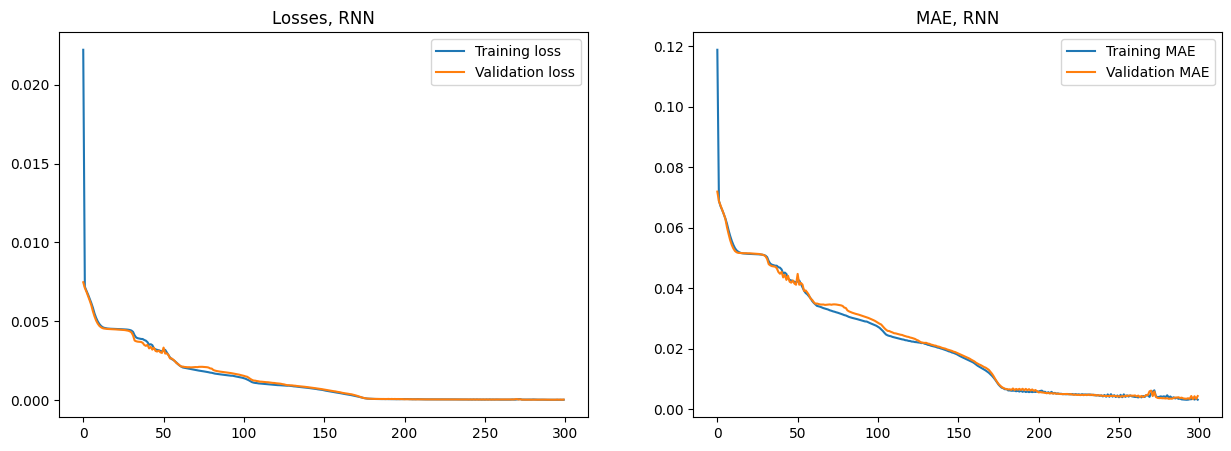

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses_rnn, label='Training loss')
ax[0].plot(val_losses_rnn, label='Validation loss')
ax[0].legend()
ax[0].set_title('Losses, RNN')
ax[1].plot(train_maes_rnn, label='Training MAE')
ax[1].plot(val_maes_rnn, label='Validation MAE')
ax[1].legend()
ax[1].set_title('MAE, RNN')
plt.show()

I will go with 300, since I do not see any possible huge improvement.
Let's retrain again with the whole set

In [147]:
final_model_rnn = VanillaRNN(1, best_result_rnn[0], 1, nonlinearity='relu')
optimizer = torch.optim.Adam(final_model_rnn.parameters(), lr=0.0001, weight_decay=1e-6)
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()
train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = train_rnn(final_model_rnn, optimizer, loss_fn, mae_fn, x_dev, y_dev, None, None, prop_length=64)

Training, epoch: 0:   0%|          | 0/300 [00:00<?, ?it/s]

Training, epoch: 299: 100%|██████████| 300/300 [07:53<00:00,  1.58s/it, loss=1.89e-5, mae=0.00378] 


### Testing and Visualizations

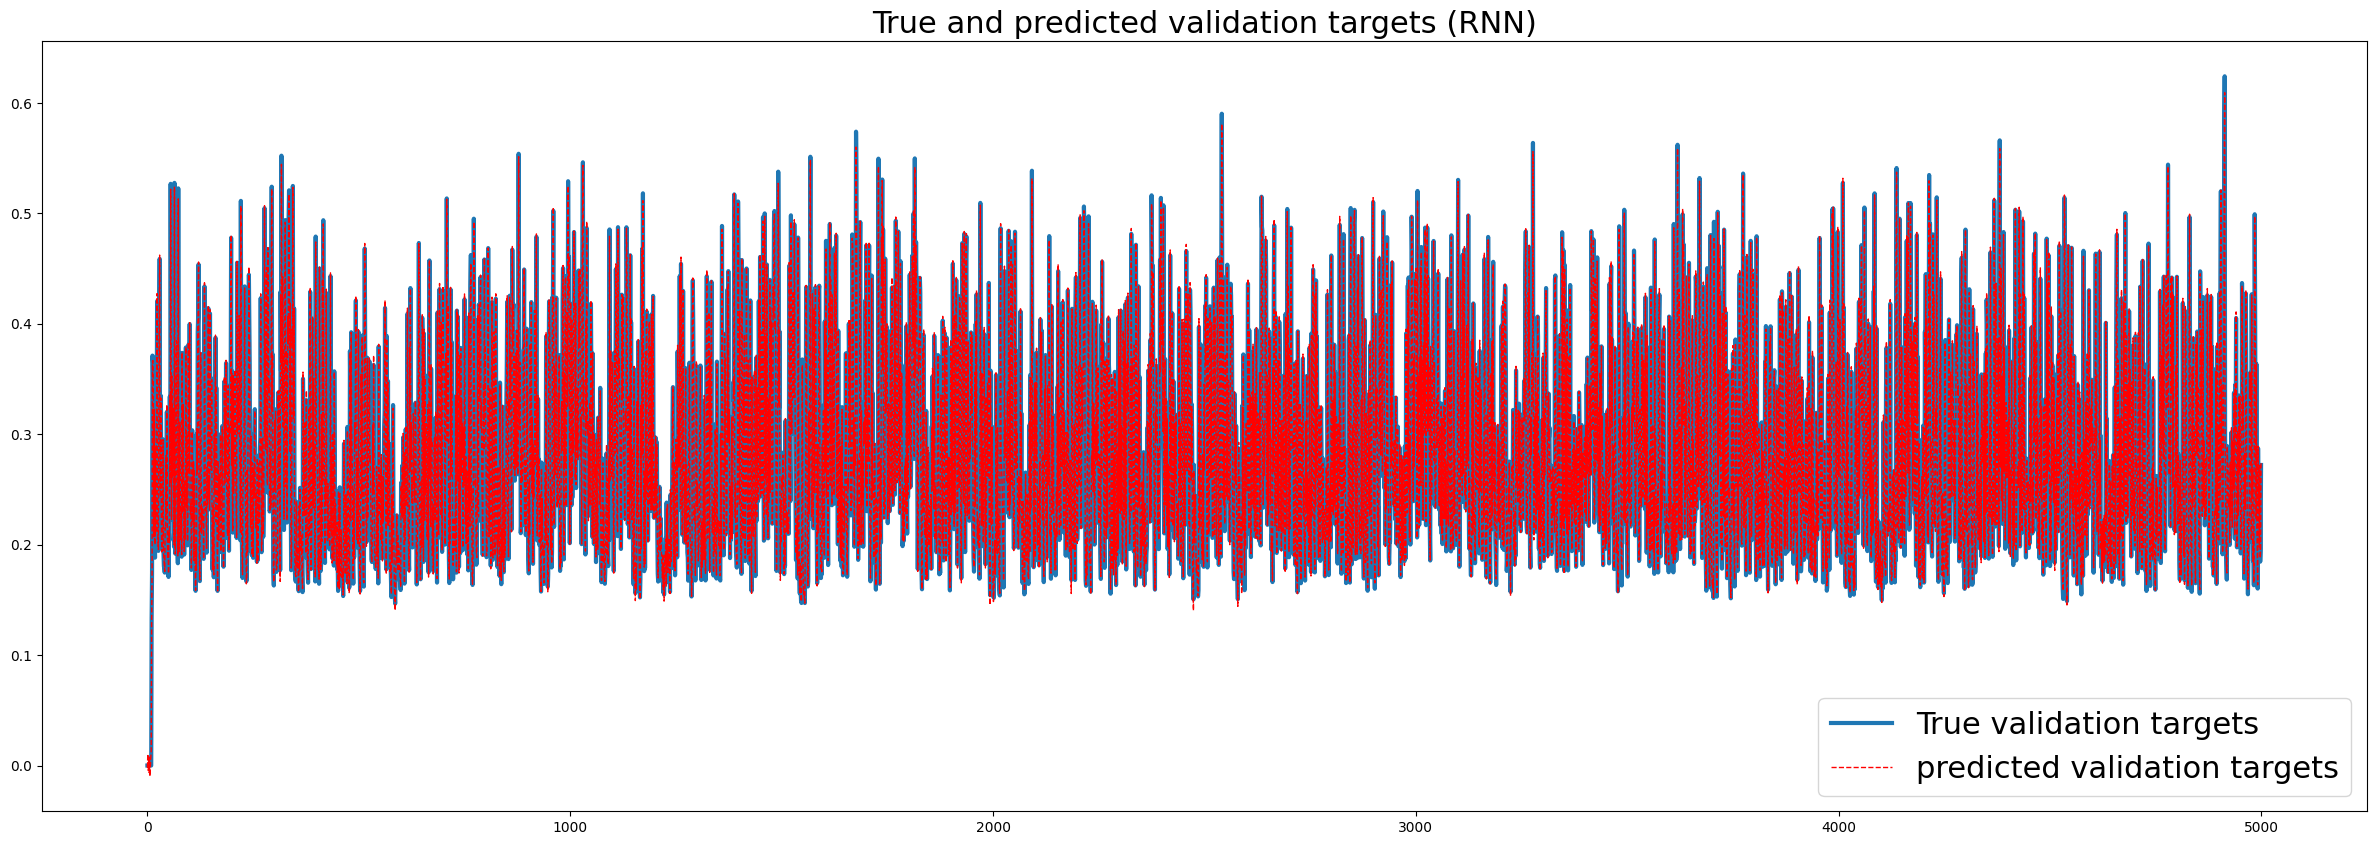

In [152]:
y_hats_rnn = torch.Tensor()
h_last = None
for i in range(0, x_dev.shape[1], 64):

    x_batch = x_dev[:, i: i + 64]
    y_hat, h_last = final_model_rnn(x_batch, h_last)
    y_hats_rnn = torch.cat((y_hats_rnn, y_hat), dim=1)

plt.figure(figsize=(30,10))
y_hats_rnn = y_hats_rnn.reshape(-1)
plt.plot(y_dev.reshape(-1), label ='True validation targets', linewidth=3)
plt.plot(y_hats_rnn.detach().numpy(), label ='predicted validation targets', linestyle = '--', color='r', linewidth=1)
plt.title('True and predicted validation targets (RNN)', fontsize=22)
plt.legend(fontsize=22)
plt.show()

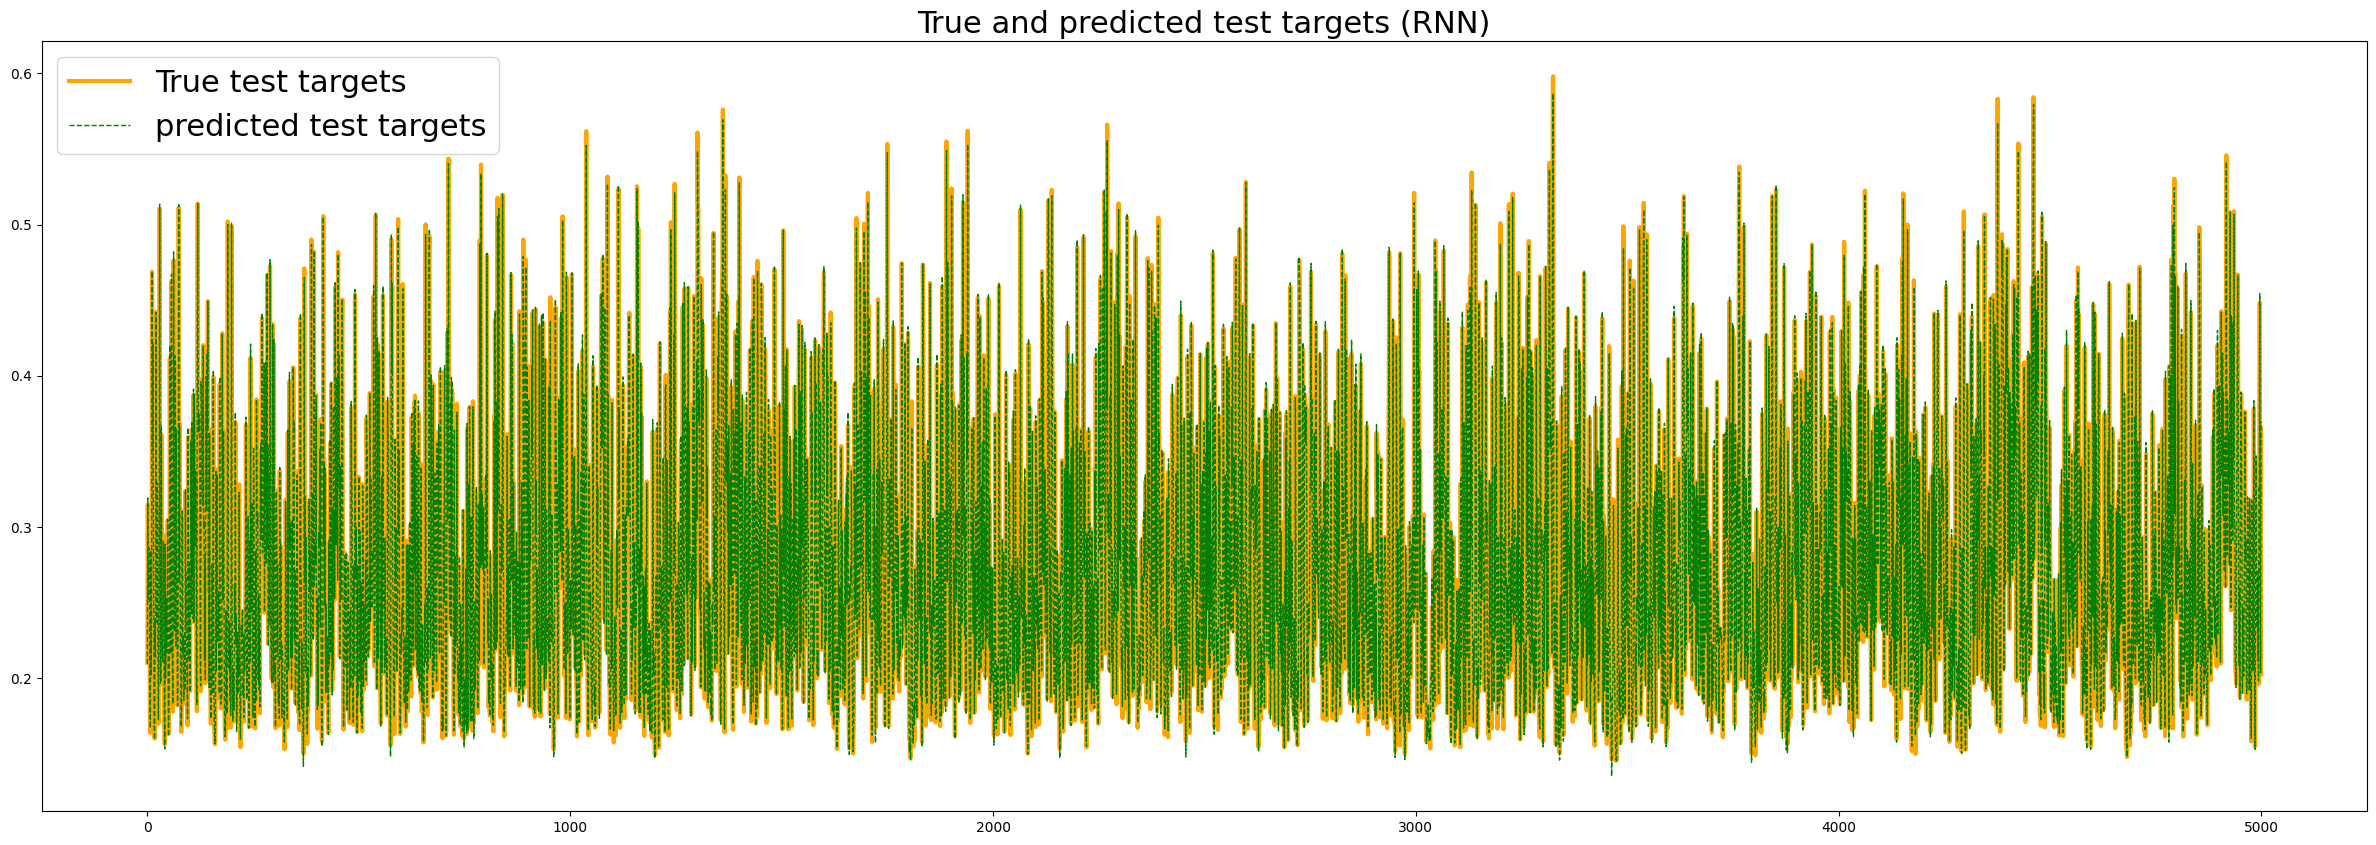

In [184]:
y_hats_test_rnn = torch.Tensor()



for i in range(0, x_test.shape[1], 64):
    x_batch = x_test[:, i: i + 64]
    y_hat, h_last = final_model_rnn(x_batch, h_last)
    y_hats_test_rnn = torch.cat((y_hats_test_rnn, y_hat), dim=1)

plt.figure(figsize=(30,10))
y_hats_test_rnn = y_hats_test_rnn.reshape(-1)
plt.plot(y_test.reshape(-1), label ='True test targets', linewidth=3, color='orange')
plt.plot(y_hats_test_rnn.detach().numpy(), label ='predicted test targets', linestyle = '--', color='g', linewidth=1)
plt.legend(fontsize=22)
plt.title('True and predicted test targets (RNN)', fontsize=22)
plt.show()


In [185]:
y_test.shape

torch.Size([1, 5000, 1])

In [219]:
final_results["RNN"] = dict()
final_results["RNN"]["hyperparameters"] = { "hidden_size": best_result_rnn[0], "lr": 0.0001, "wd": 1e-6, "nonlinearity": "relu", "propagation_steps": 64 }
final_results["RNN"]["train_loss"] = loss_fn(y_hats_rnn, y_dev.reshape(-1)).item()
final_results["RNN"]["train_mae"] = mae_fn(y_hats_rnn, y_dev.reshape(-1)).item()
final_results["RNN"]["test_loss"] = loss_fn(y_hats_test_rnn, y_test.reshape(-1)).item()
final_results["RNN"]["test_mae"] = mae_fn(y_hats_test_rnn, y_test.reshape(-1)).item()
pprint(final_results)

with open('final_results.json', 'w') as f:
    json.dump(final_results, f)

{'RNN': {'hyperparameters': {'hidden_size': 200,
                             'lr': 0.0001,
                             'nonlinearity': 'relu',
                             'propagation_steps': 64,
                             'wd': 1e-06},
         'test_loss': 1.37486485982663e-05,
         'test_mae': 0.0028403885662555695,
         'train_loss': 1.1044003258575685e-05,
         'train_mae': 0.002583319554105401},
 'TDNN': {'hyperparameters': {'hidden_size': 100,
                              'lr': 0.01,
                              'window_size': 20},
          'test_loss': 0.00012564109056256711,
          'test_mae': 0.010114632546901703,
          'train_loss': 0.00011963090219069272,
          'train_mae': 0.009891877882182598}}


In [215]:
# save model
torch.save(final_model_rnn.state_dict(), 'final_model_rnn.pth')
torch.save(final_tdnn.state_dict(), 'final_model_tdnn.pth')

## Final Considerations
Overall the two methods could solve the problem pretty well.
RNN proved to be significantly better, but considering the number of training epochs and the efficiency of the model, training was more expensive.
The hyperparameter tuning was also more difficult for the recurrent network, with the possibility to encounter problems of exploding gradient (see also next plots).


## Previous Experiments and Gradient Issues

These visualizations were made training on the whole time series at once (i.e. back propagating through the whole sequence).
Here we can see how the network fails to train: with a too small learning rate, the loss has a plateau at a high value. If the learning rate is too high, the magnitude of te graidents make the learning very unstable

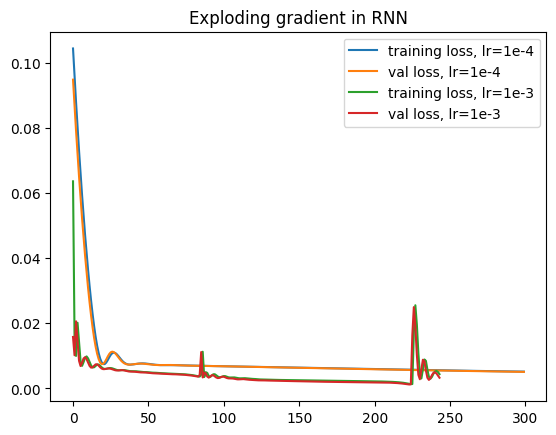

In [73]:
plt.title("Exploding gradient in RNN")
plt.plot(results_rnn[(200, 0.0001, 1e-08)][0], label = 'training loss, lr=1e-4') # training loss
plt.plot(results_rnn[(200, 0.0001, 1e-08)][2], label = 'val loss, lr=1e-4') # validation loss
plt.plot(results_rnn[(200, 0.001, 1e-08)][0], label = 'training loss, lr=1e-3') # training loss
plt.plot(results_rnn[(200, 0.001, 1e-08)][2], label = 'val loss, lr=1e-3') # validation loss
plt.legend()
plt.show()

The training for the $10^{-3}$ learning rate was very instable, as we can see from the training curve:
This is very likely due to exploding gradient issues.
Nevertheless, before exploding the loss was lower than with $10^{-4}$ learning rate. I'm now trying again to fit the models clipping the gradient.

In [78]:
hidden_sizes = [100, 200]
learning_rates = [1e-3]
weight_decays = [1e-8, 1e-6]
gradient_clips = [1, 10]
#nonlinearities = ['tanh'] # from previous experiments, relu performs poorly
results_rnn = dict()
for hidden_size, lr, wd, g_clip in product(hidden_sizes, learning_rates, weight_decays, gradient_clips):
    print(f'Hidden size: {hidden_size}, Learning rate: {lr}, Weight decay: {wd}, Gradient clip: {g_clip}')
    rnn = VanillaRNN(1, hidden_size, 1, 'tanh')
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()
    train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = train_rnn(rnn, optimizer, loss_fn, mae_fn, x_train, y_train, x_val, y_val, gradient_clip=g_clip)
    results_rnn[(hidden_size, lr, wd, g_clip)] = (train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn)


Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-08, Gradient clip: 1


Training, epoch: 135:  45%|████▌     | 135/300 [01:04<01:18,  2.10it/s, loss=0.00495, mae=0.055, val_loss=0.00465, val_mae=0.0534] 


Early stopping triggered after 136 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-08, Gradient clip: 10


Training, epoch: 299: 100%|██████████| 300/300 [02:24<00:00,  2.08it/s, loss=0.00231, mae=0.0362, val_loss=0.00232, val_mae=0.0371]


Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-06, Gradient clip: 1


Training, epoch: 223:  74%|███████▍  | 223/300 [01:45<00:36,  2.12it/s, loss=0.00351, mae=0.0453, val_loss=0.00331, val_mae=0.0443]


Early stopping triggered after 224 epochs.
Hidden size: 100, Learning rate: 0.001, Weight decay: 1e-06, Gradient clip: 10


Training, epoch: 162:  54%|█████▍    | 162/300 [01:16<01:05,  2.12it/s, loss=0.00422, mae=0.05, val_loss=0.00398, val_mae=0.0494]  


Early stopping triggered after 163 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-08, Gradient clip: 1


Training, epoch: 122:  41%|████      | 122/300 [01:27<02:07,  1.40it/s, loss=0.00349, mae=0.0452, val_loss=0.00324, val_mae=0.044] 


Early stopping triggered after 123 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-08, Gradient clip: 10


Training, epoch: 173:  58%|█████▊    | 173/300 [02:06<01:33,  1.37it/s, loss=0.00463, mae=0.0527, val_loss=0.00375, val_mae=0.0473]


Early stopping triggered after 174 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-06, Gradient clip: 1


Training, epoch: 89:  30%|██▉       | 89/300 [01:05<02:35,  1.36it/s, loss=0.00455, mae=0.0529, val_loss=0.00449, val_mae=0.053] 


Early stopping triggered after 90 epochs.
Hidden size: 200, Learning rate: 0.001, Weight decay: 1e-06, Gradient clip: 10


Training, epoch: 123:  41%|████      | 123/300 [01:23<01:59,  1.48it/s, loss=0.0035, mae=0.0452, val_loss=0.00338, val_mae=0.0453] 

Early stopping triggered after 124 epochs.


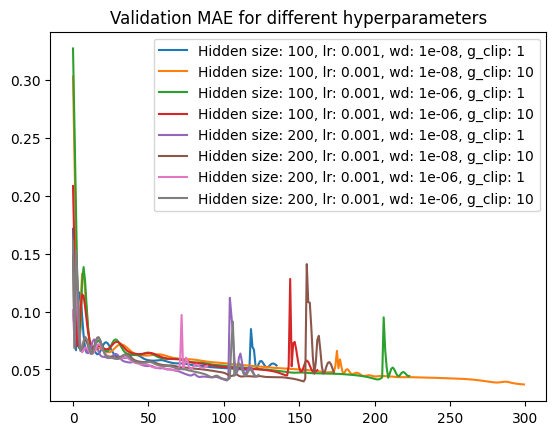

In [83]:
for result in results_rnn:
    train_losses_rnn, train_maes_rnn, val_losses_rnn, val_maes_rnn = results_rnn[result]
    plt.plot(val_maes_rnn, label=f'Hidden size: {result[0]}, lr: {result[1]}, wd: {result[2]}, g_clip: {result[3]}')
plt.legend()
plt.title('Validation MAE for different hyperparameters')
plt.show()

Still very bad... 

Training in batches, we did not need the clipping at all.